# Convolution Neural Networks

Let's begin by loading some of the tools we will need to this job. We will utilize Keras for building/training our neural network and matplotlib for plotting and visualization, and numpy for *everything* (period).

In [1]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K

import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

## The Data

Let's use one of the most common image data sets used to benchmark convolution network implementations: MNIST. We explored it some in other introductions, so I'll let it speak for itself this time around. Please see the Single- and Multi-layer tutorials (earlier lab assignments if you are in the course) before attempting this assignment if needed: [Link](https://github.com/CSCI4850/notebook-examples)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

In [3]:
## Standardize the -input- data between [-1.0,1.0] (real)
## instead of the default 0-255 (integer)
x_train = x_train.astype('float32').reshape(x_train.shape+(1,))
x_test = x_test.astype('float32').reshape(x_test.shape+(1,))
x_train = 2.0 * (x_train / 255.0) - 1.0
x_test = 2.0 * (x_test / 255.0) - 1.0

# Convert class vector [0-9] to categorical assignments (one-hot)
y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test = keras.utils.to_categorical(y_test, len(np.unique(y_test)))

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(60000, 28, 28, 1)

(60000, 10)

(60000, 28, 28, 1)

(10000, 10)

Remember that these are greyscale images, so there is just a single intensity value for each pixel. Full color images would need to have _3_ channels (red, green, blue) for processing. Even though this is the case, Keras `Conv2D` layers expect that images have *three* dimensions (3D tensors) and so you must explicitly set this third dimension to 1 for it to accept each image as input. This is why the shapes above for the *input* patterns, $\boldsymbol{X}$, are (n, 28, 28, 1) where each of the patterns is a 28x28x1 image. The `reshape()` function was used to add this extra dimension (wich a size of 1) to the data tensors.

Let's create a convolution neural network for solving the MNIST problem. Remember, in the last lab we used a standard deep-learning or multi-layer neural network approach. We improved the performance by changing from Tanh to ReLU, and deeper networks instead of wider networks. In this way, we tried to tune the *inductive bias* of the network to form a nested solution to the problem (which isn't as easy to do with just one hidden layer). This approach performed quite well, but we are hoping to make the network even better by tuning the inductive bias even more by using the convolution approach.

The convolution network will consist mostly of **filters** or **kernels** (small neural networks which will each learn to detect a single feature in the image) which can be used to *scan* the entire image to find where such features are present. We can apply additional filtering downstream in a similar way to construct groups of features, and finally a *pooling* method to detect those features in a reliable way regardless of where they are in the image. This means that we are adding an inductive bias to eliminate variance in the translation of such features from image to image. In other words, we want to create an inductive bias to develop translation-invariant representations in our network.

In [4]:
model = keras.Sequential()
# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
model.add(keras.layers.Conv2D(64, kernel_size=(8, 8),
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]]))
model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 21, 64)        4160      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       524416    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

This is a pretty big network, no? Over 1 million connection weights! The convolution layers are applied twice over over the image before applying a pooling step, so the number of units *even after pooling* is quite large. Once flattened, this creates a large set of weights to the immediate dense layer which follows. The result is funneled into a smaller layer before using a softmax layer to categorize the image. 

## Counting Connection Weights...
Before moving on, let's unpack some of the output from the `summary()` function to understand what has happened here. There are *a lot of weights*, so it's worth **thinking about what they are doing and where they came from**.

First, the initial `Conv2D` layer has 4160 parameters (connection weights). We selected a layer size of `64` when making the layer, so we are creating 64 different *feature detector* units which we will slide around (convolve with) the image in order to detect this feature anywhere in the image. Each unit gets its own bias weight (64 bias weights total), so there are 4096 weights left unaccounted for. For those weights, each feature detector was requested to make a `kernel_size` of 8 x 8 pixels (that's 64 weights for each unit) and so 64 x 64 = 4096. All weights for this layer are now accounted for. The same weights are used at each 8 x 8 patch in the image (overlapping and crossing) because we want each unit to become a dedicated *feature detector* during the learning process. The keras framework will automatically set up the layer to slide each of the feature detectors across all 8 x 8 pixel regions in the image as I just described.

There is an additional hyper-parameter, *stride*, which could be adjusted as well to make the detector skip over a certain number of pixels each time the filter is applied. This would speed up the computation, but may miss features in the image if it is set too large. The default value is one, which is what we want, so I didn't specify *stride* at all when creating the layer. Think about this a little more, we can see that this means there are 21 x 21 unique 8 x 8 patches within this image, so that each unit calculates an activation value for each of the 441 (21 x 21) locations, but these activation patterns stay arranged in a 21 x 21 grid just like a 2D image. This means that the output for this layer is 21 x 21 x 64 in size... getting big, right? Preserving this 2D topology is important so that subsequent (downstream) layers can utilize this arrangement as well (for example, to find groups of features which are close to one another in the image).

Now, for the second `Conv2D` layer, there are 524416 weights (WOW!). So, how do we account for all of those weights? Well, first we again start with the number of units requested, in this case 128. Each has a single bias weight, which leaves us with 524288 weights unaccounted for so far. There is again an 8 x 8 kernel requested at this layer, so each unit has a set of 64 weights assigned to it, but only within *one* of the 21 x 21 grids from the previous layer (and there are 64 of those 2D grids since each filter/detector was used in this way). So, 64 (kernel weights) x 128 (units) x 64 (prev units) = 524288, and all weights are now accounted for. Finally, each of these 128 units is being slid across the 21 x 21 grid from the previous layer using the 8 x 8 kernel, and there are 14 x 14 = 196 unique patches. Again, the 14 x 14 arrangement of the activation outputs is maintained for each of the 128 units to retain 2D structure. However, we have now created a double convolution (complex features detected as convolutions of simpler features).

We follow up with a `MaxPooling2D` layer with a kernel size of 2 x 2. This means that we downsample the 14 x 14 grids from the previous layer with *nonoverlapping* patches of 2 x 2, and retain the maximum in this region (because it's most likely that only *one* complex feature will be detected in any of these distinct patches). This also helps with reducing the size of the activations from the previous layer by half from 14 x 14 x 128 down to 7 x 7 x 128. An additional `Dropout()` layer is also added here to encourage the network to be robust to missing features (maybe forcing different units in the convolutional layers to be somewhat redundant and tuning the inductive bias to make the network hopefully generalize a little better to new images it has yet to see).

The `Flatten()` layer is designed to remove the tensorial structure of the activation (layer output) vectors at this point. Since we have 7 x 7 x 128 = 6272, it just reshapes the output from the previous layer into the flattened 1D vector of activations (1 x 6272). This allows us to stack standard `Dense` (and `Dropout`) layers from now on in the network, but the calculating the number of connection weights is now much easier. For example, after the `Flatten` layer, we have a layer of 128 units (`Dense`), so the weight matrix contains 6272 x 128 + 128 (bias weights) = 802944 connection weights total. After an additional `Dropout` layer, we have a `Dense` layer of 10 units (the output layer), so 128 x 10 + 10 (bias weights) = 1290 connection weights. Therefore, all parameters can be accounted for in the convolution and flattening process.

**It's important to think through this exercise to understand how the network is wired up if you plan to use convolution nets on your particular problem...**

## Training Time

OK, hold up just one second. One thing you need to understand is that this is a *big* network and there is *a lot* of data moving through it. It's not large compared to what some research groups train these days, but working on a standard desktop will still require a *several* minutes to train it up (for example, Biosim will take about 5 minutes per epoch, so about 25 minutes total for just 5 epochs). If you complete this cycle of training, you can expect > 98% accuracy on the testing data at the end of the day.

In [5]:
batch_size = 512
epochs = 5
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.2)

Epoch 1/5
94/94 [==============================] - 50s 533ms/step - loss: 0.7299 - accuracy: 0.7550 - val_loss: 0.0785 - val_accuracy: 0.9760
Epoch 2/5
94/94 [==============================] - 49s 522ms/step - loss: 0.1075 - accuracy: 0.9690 - val_loss: 0.0513 - val_accuracy: 0.9851
Epoch 3/5
94/94 [==============================] - 49s 522ms/step - loss: 0.0655 - accuracy: 0.9806 - val_loss: 0.0475 - val_accuracy: 0.9861
Epoch 4/5
94/94 [==============================] - 49s 523ms/step - loss: 0.0511 - accuracy: 0.9846 - val_loss: 0.0384 - val_accuracy: 0.9888
Epoch 5/5
94/94 [==============================] - 49s 522ms/step - loss: 0.0418 - accuracy: 0.9878 - val_loss: 0.0360 - val_accuracy: 0.9898


In [11]:
# Final Result - Generalization!
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0277 - accuracy: 0.9916
Test loss: 0.02773233689367771
Test accuracy: 0.991599977016449


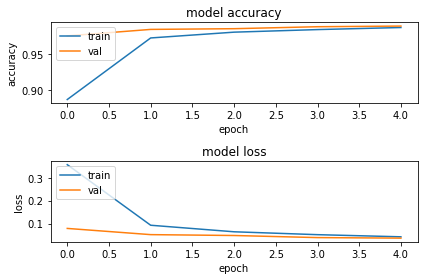

In [14]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left') 

plt.tight_layout()
plt.show()  

## Examining the Weights

Let's see if we can get a glimpse into what the network has learned by unpacking some of the weights in the network and plotting them. Since the kernel patches have a 2D structure to them, we would expect the network to start learning interesting 2D features which capture edges and common shapes in these small patches that can be stitched together to form composite digits. These features are what a convolution network is all about: changing the inductive bias of the network to better capture the kinds of features useful for classifying 2D/image data.

OK, so we can use the `get_weights()` function to grab them, and we expect 8 sets of them. This is because 4 layers in the network construction introduced connection weights (only four rows in the summary have a non-zero entry in #Params). Also, connection weights and bias weights for each layer are divided into two separate tensors each (4 x 2 = 8). The connection weights will not be matrices since the addition of 2D structure rearranges them based on the selected kernel size.

Let's grab one set, and then many more...

In [15]:
# This is everything!
weights = model.get_weights()

In [16]:
# How many tensors?
len(weights)

8

In [17]:
# What's the shape of the tensor
# for the connection weights at
# the -first- Conv2D layer?
weights[0].shape

(8, 8, 1, 64)

Notice how the filters are 8 x 8 x 1 (64 filters total since there are 64 units in that layer). We can slice off the dimension of size 1 by just grabbing index 0 along that dimension. Slicing along the dimension of size 64 will get an individual filter: for now, lets just look at the first one and see what we find.

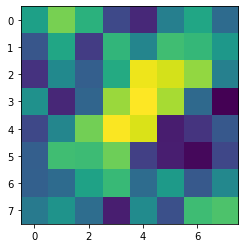

In [18]:
# We can plot the kernel weight matrix
# for just the first unit (out of 64)
# as an example...
plt.imshow(weights[0][:,:,0,0])
plt.show()

The light values indicate high weights, and the dark regions indicate low weights. In general, high weights cause a unit to turn on when pixel intensities are high and low weights cause a unit to turn off when pixel intensities are high. Therefore regions which transition from high to low weights are finding edges. Different units will detect different shape and orienations of these edge features, which form the basic building blocks for object detection and recognition. We can look at all 64 of the units by creating a plot with 64 small 8 x 8 subplots.

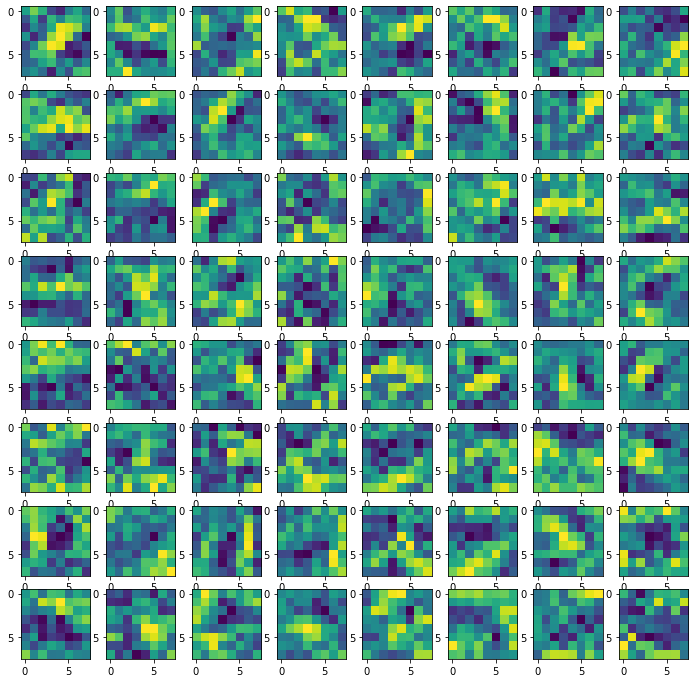

In [19]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        data = weights[0][:,:,:,(x*8)+y].reshape(8,8)
        
        axes[x,y].imshow(data)
plt.show()

These edge features are  then combined at the next `Conv2D` layer to form more complex features, so they are detecting changes in observed features.

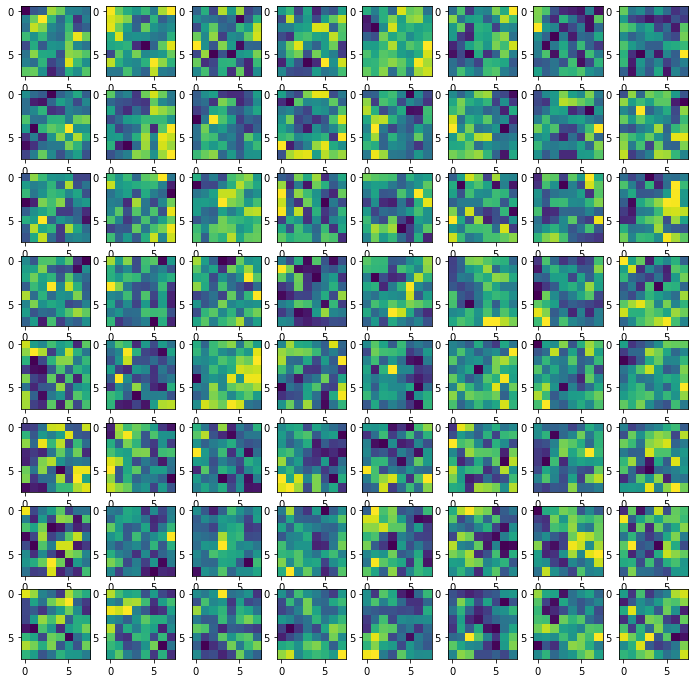

In [20]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        axes[x,y].imshow(weights[2][:,:,(x*8)+y,0].reshape(8,8))
plt.show()

## Exploring the Network Activations

While looking at the weights can provide some insights into the function of these filters/kernels/"feature detectors", it doesn't show how the weights are used for any *particular* image. Therefore, it can be hard to see how these weights are *used* by the network when classifying a digit. In order to gather additional insight on what the network might have learned, we can instead send a pattern through the network and look at the *activation values* produced by the units at each layer. We would expect the feature detectors to turn on in different ways based on the different digits which are presented, essentially based on the features which are present or not present in a given image.

Too start with, let's pass a single image (the first one in the x_train data set) through the network and extract the activations of the neurons for all layers...

In [22]:
# Extract the input layer/tensor of the model
inp = model.input

# Extract the output layer/tensors of the model
# Note: there is one output tensor for each layer
#       which contains the activation values
#       for the layer in question...
out = [layer.output for layer in model.layers]

# Create a function to obtain the outputs given
# an input tensor...
functor = K.function(inp, out)

In [24]:
# Get the layer outputs for the -first- image...
layer_outputs = functor(x_train[0:1,:,:,:])
len(layer_outputs)

8

We have passed the first image through the network, and have extracted the activations for the 8 layers. Now we can visualize those activations to see what these feature detectors might be finding.

First, we look at the initial convolutional layer of the network...

In [25]:
layer_outputs[0].shape

(1, 21, 21, 64)

Looking at the dimensions of the output tensor for the first layer, we can observe that there are 64 units each with a 1 x 21 x 21 output tensor. The 1 is due to the fact that we only have one channel (intensity). The 21 x 21 corresponds to the sliding of the 8 x 8 filters across the 28 x 28 pixel input images. Let's plot each of those 21 x 21 activation patterns to see if there is anything interesting there...

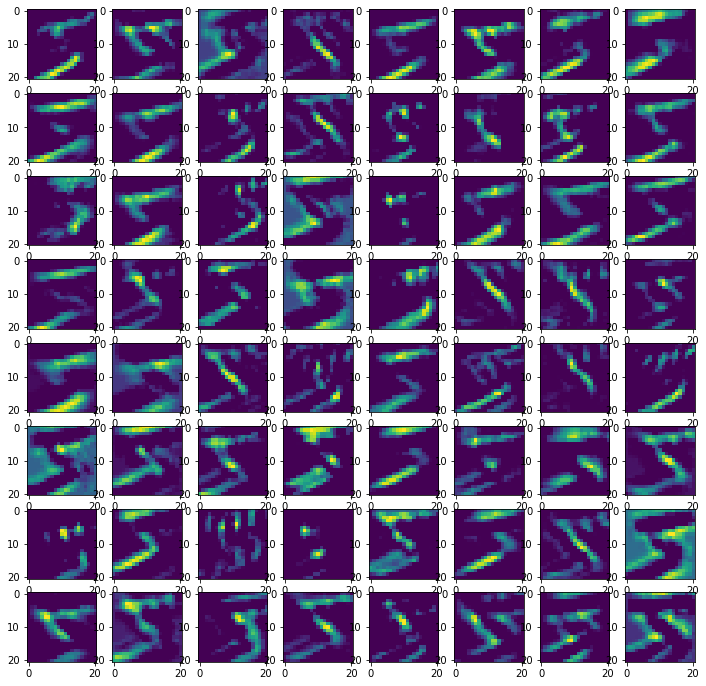

In [26]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        axes[x,y].imshow(layer_outputs[0][0,:,:,(x*8)+y])
plt.show()

It should be pretty clear that these units are detecting simple features for the number 5, which is indeed the first image in the x_train set. You might notice that some of the neural units seem to be finding edges or boundaries. Some units find edges or other features on just one side, some on both sides, and others seem to detect empty or surrounding regions which *lack* pixels.

What would we find in the second layer? This one is a little more complicated since it's composites of features and there are 128 units. Still, we can try the same approach...

In [27]:
layer_outputs[1].shape

(1, 14, 14, 128)

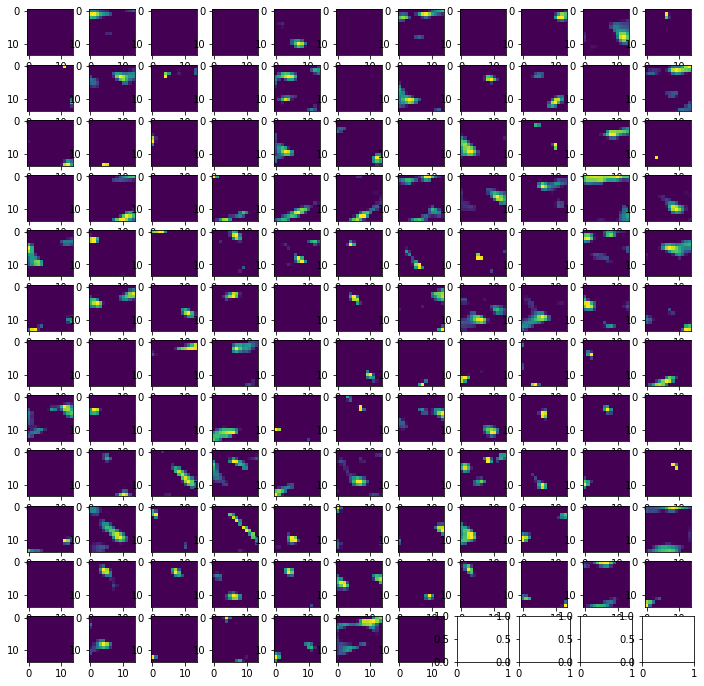

In [28]:
fig,axes = plt.subplots(12,11)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(128):
    axes[int(x/11),int(x%11)].imshow(layer_outputs[1][0,:,:,x])
plt.show()

Such composite features are somewhat difficult to understand without sampling from a wide range of images, but these are basically combinations of features that are somewhat unique to the number 5. Of course some of them will be active for numbers that look similar in certain ways, but the key *differences* will also be observed in these activation patterns.

Given that the downstream layers should start to look less like composite features, but unique vectors for describing each image, we can now try to visualize those vectors using PCA...

In [29]:
# How many of the training images to use?
n_train = 1000

# Extract the outputs for -all- requested patterns
layer_outputs = [functor(test[np.newaxis,...]) for test in x_train[0:n_train,:,:,:]]

# Extract just the activations of the -sixth- layer in the network.
# Remember, this is a -dense- layer with 128 neural units.
# We can think of this as a 128-dimensional space in which each 
# of the patterns has now been embedded by the neural network...
A = np.vstack([out[5].flatten() for out in layer_outputs])

A.shape

(1000, 128)

The matrix, $\boldsymbol{A}$, now contains the activations of the 6th layer of the network (dense, 128 units) for the first 1000 training patterns. Of course, we can't visualize a 128-dimensional space, but using PCA we can project this down to a smaller number of dimensions and see if we can observe any trends.

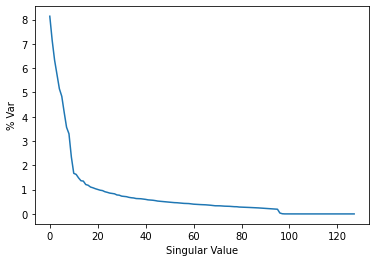

In [30]:
# Mean center a vector
def mean_center(x):
    return x - np.mean(x)

# Call this function for each column in the data (move along axis 0 or the rows)
Acentered = np.apply_along_axis(mean_center,0,A)

U,S,V = np.linalg.svd(Acentered,full_matrices=True)

# Percent variance accounted for
plt.plot(100.0*S/np.sum(S))
plt.ylabel('% Var')
plt.xlabel('Singular Value')
plt.show()

The scree plot above shows that it still takes a large number of dimensions to embed the data. However, maybe a 3D projection will show a decent amount of information.

In [31]:
100.0*np.sum(S[0:3])/np.sum(S)

21.612345142805992

The first 3 principal components will only capture about 20% of the variance in the data, but let's color the plot by the various classes and see if it looks better than the PCA of the original data which we saw back in Open Lab 4.

In [32]:
D = np.zeros([A.shape[0],A.shape[1]])
np.fill_diagonal(D,S)
Arotated = np.dot(U,D)

# First three principal components!
PCs = Arotated[:,0:3]
PCs.shape

(1000, 3)

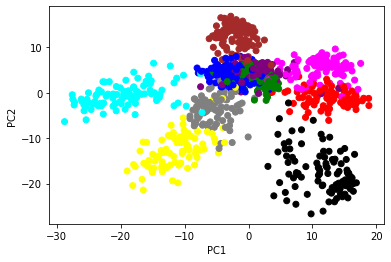

In [33]:
# Need a lot of colors again (10 - one for each class)
# PCs 1 and 2
plt.scatter(PCs[:,0],PCs[:,1],
            color=[['red','green','blue','cyan','magenta',
                    'yellow','black','brown','grey','purple'][i]
                   for i in np.apply_along_axis(np.argmax,1,y_train[0:n_train,:])])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

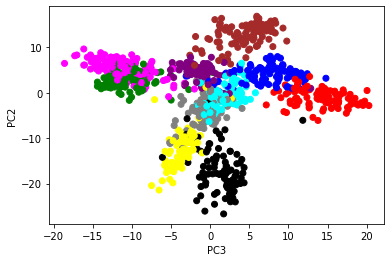

In [34]:
# PCs 2 and 3
plt.scatter(PCs[:,2],PCs[:,1],
            color=[['red','green','blue','cyan','magenta',
                    'yellow','black','brown','grey','purple'][i]
                   for i in np.apply_along_axis(np.argmax,1,y_train[0:n_train,:])])
plt.xlabel("PC3")
plt.ylabel("PC2")
plt.show()

The two plots above utilize 2 separate 2D plots to attempt to visualize the first 3 principal components. The first shows PCs 1 and 2 while the second shows PCs 2 and 3. Therefore, they share PC 2 which can help show where one plot corresponds to the other. Also, if some groups are overlapping in one plot, they are usually not in the other (or they do not overlap in either plot). Therefore, it looks like the 128-dimensional embedding created at the downstream dense layer is providing a good space in which decision boundaries (hyper-planes) between the different classes might easily be drawn.

Using a 3D plot can make this a little clearer, but it's difficult to render just the right angle for viewing all of the point clouds. Let's render at a couple of different angles to see if that helps...

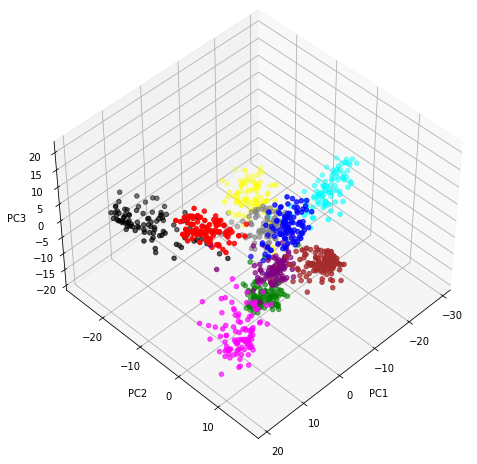

In [35]:
# 3D Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.scatter(PCs[:,0],PCs[:,1],PCs[:,2],
           color=[['red','green','blue','cyan','magenta',
                   'yellow','black','brown','grey','purple'][i]
                  for i in np.apply_along_axis(np.argmax,1,y_train[0:n_train,:])])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.view_init(45,45)

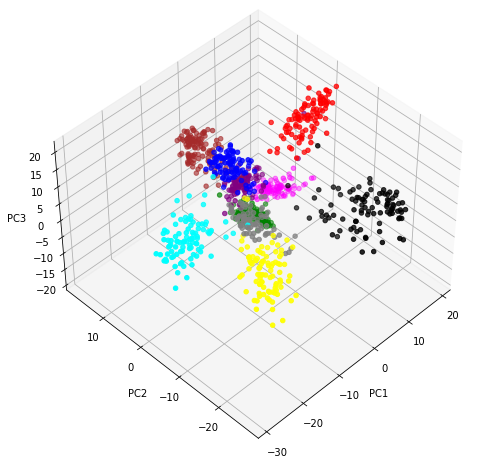

In [36]:
# 3D Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.scatter(PCs[:,0],PCs[:,1],PCs[:,2],
           color=[['red','green','blue','cyan','magenta',
                   'yellow','black','brown','grey','purple'][i]
                  for i in np.apply_along_axis(np.argmax,1,y_train[0:n_train,:])])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.view_init(45,225)

This PCA projection shows that the 10 classes are fairly well separated, and that's using a projection which only accounts for 20% of the total variance in the data. Even still, it is clear that the network has learned to separate the different images into unique regions of the neural activations space. This allows the final output layer to form a clear decision boundary between the different image classes and achieve *very good* (almost state-of-the-art) performance with just a handful of training epochs. That's a pretty helpful inductive bias, no?

In the end, the general approach to plotting weights may help us to understand what's happening for *all* patterns, but analyzing activations can provide additional insights since they change and vary with the input data itself. Still, this often requires some additional post-processing which may be prohibitively expensive. For example, we could have tried the same approach with the activations of the convolution layers, but the size of the activations matrices is much larger than the later downstream layers. This would make the PCA prohibitively expensive to perform. Later in the semester, we will look at a way to train a neural network to solve PCA which will require epochs of training but is much more memory efficient than the SVD approach used above.

We've now built and trained a basic convolution neural network, but there's more on this to come soon!

## Using a Pre-trained Model (Transfer Learning)

Now that we have explored building a ConvNet from scratch using MNIST, let's explore two more potentially useful techniques:
1. 3-channel (R,G,B) images
2. Pre-trained ConvNet for early stages of processing

We will utilize full-color images (increasing the third dimension of our input tensors to 3). Images will be of a different size now as well since we will build the convolution layers of our network using a *pretrained* set of layers and connection weights which have already been trained on an extensive set of images. This is useful since we don't necessary have the time and memory resources to burn on training up the low-level features useful for generalized classification. Instead, we will exploit the pre-trained network topology and then stack some additional layers on top of these pre-trained layers to perform our *particular* categorization task. This should also allow for faster training of the network since updating the connection weights on the earlier layers of the network should be minimal. This reduction in training epochs for training those deep weights in the network will significantly reduce our training time on our image classification task of interest.

First though, we need to load up an image data set to use. This example will consist of 100 images borrowed from [ImageNet](http://www.image-net.org). I've already prepared the data set and posted it on the course website [https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/xception_example.zip](https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/xception_example.zip). You should download the data set (just use the terminal to download and unpack them into your home directory):
```
wget <paste-a-copy-of-the-link-here-instead>

unzip xception_example.zip
```
You will need to adjust some of the paths below to perform these commands yourself. Some of the image processing tools that can read images from URLs directly were also performing some additional processing of the images that might not be compatible with this tutorial, so we won't use such tools until that gets fixed.

OK, let's load up some images and see what we have (make sure you **change /home/jphillips** to the location where you unpacked your images)...

In [37]:
# First a few tools for this -particular- example...
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [39]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

X = np.concatenate(
    [grab_image('/home/jphillips/xception_example/images/image_%d.JPEG'%(i))
     for i in range(100)])
X.shape

(100, 299, 299, 3)

You will note that this is a *4D tensor* of input data for the network. The first dimension is 100 since there are 100 images, each image is 299 x 299 pixels (dims 2 and 3), and the last dimension is of size 3 for the three color channels of the image (red, green, blue). After the above code has been run, each image has already been preprocessed for input into the pre-trained network that we will be using: Googles's Xception net.

If you want to verify any of the images though, you can reconvert the preprocessed arrays *back* into an image format accepted by matplotlib, and use `imshow()` to display it.

For example:

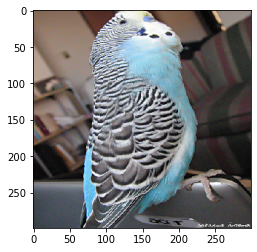

In [40]:
plt.imshow(image.array_to_img(X[0,:,:,:]))
plt.show()

That's a parakeet, and the next is a dog hanging out with some sheep!

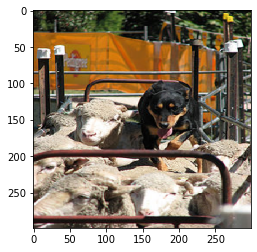

In [41]:
plt.imshow(image.array_to_img(X[1,:,:,:]))
plt.show()

Now we will load up a pre-trained model (Google's Xception) which classifies any provided image (scaled to 299 x 299 pixels) into one of 1000 different categories (the output layer has 1000 units and a softmax activation function). This network is pretty large (but still small compared to some convnets) so get ready...

In [42]:
# Let's load up the model
# This will load up the architecture
# and then the pre-trained weights from the
# internet...
model = Xception(weights='imagenet')
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

That's a big network, no? Even though the network is very deep, the total number of parameters is only about 23 million, which is actually *very* compact and this is still an excellent network for image classification. Let's just use the default architecture and see what it says about the first image in our data set using the `predict()` method.

In [43]:
# Just the first image that we say above...
preds = model.predict(X[0:1,:,:,:])

# Decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=5)[0])

Predicted: [('n01817953', 'African_grey', 0.4484159), ('n01608432', 'kite', 0.037295274), ('n01819313', 'sulphur-crested_cockatoo', 0.016664127), ('n01798484', 'prairie_chicken', 0.010966338), ('n01807496', 'partridge', 0.010686258)]


That's pretty good. There are 1000 different categories used here, so lot's of different images will be categorized pretty will with at least one of the top 5 or so results. Here, the first hit at 44.8% is a very good fit even though it's not *really* an African Grey. Even the next 4 highest probabilities are all pretty close as well (never trained on this specific class anyway).

OK, so now we can use the model to make a class prediction, but let's see if we can use the pretrained network and build our own classifier on *top* of this model. In order to do this, we will need some different class labels for our data. For these 100 images, 37 have pictures of cats. Therefore, we are going to make a simple two-class predictor (cat vs. no-cat), but use Xception as the first part of our network. Let's load the class labels, and build a net with an Xception front-end.

In [44]:
# 37 cats in there (label 1, and all else 0)
Y = np.loadtxt('/home/jphillips/xception_example/class_labels.csv')
Y = keras.utils.to_categorical(Y)

# Take a look at the first 10...
Y[0:10,:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Oh, so number 5 must be a cat picture, right?

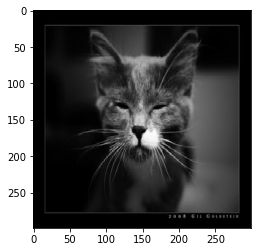

In [45]:
plt.imshow(image.array_to_img(X[4,:,:,:]))
plt.show()

OK, now the idea here is make a cat predictor, but **reuse** the pre-trained Xception network instead of starting from scratch. The basic intuition is that the low-level features extracted by Xception are very general since it was trained with a wide range of images (from 1000 different classes!). Most of those basic feature detectors should be useful for discriminating between cats and other things then as well, right?

Well, let's see...

In [46]:
# Build an Xception-based network

# Base Model
base_model = keras.applications.Xception(weights='imagenet',include_top=False)
# This model uses the trained weights, but critically,
# the include_top=False flag is provided to allow us to
# add our own layers at the top...

# New model that we are adding at the end...
# We will start by setting the -start- of the model
# to the -end- (output) of the pretrained model...
new_model = base_model.output

# Now, we can start adding our own layers to the model...
# Here, I am using the -functional- network model for
# Keras instead of the -sequential- model. This means we
# need to "manually" tie our layers together by creating
# them and then providing the upstream layer as an argument
# to the object's functional interface:
new_model = keras.layers.GlobalAveragePooling2D()(new_model)
# We are using an average pooling layer to select the most
# likely among the features provided by the base_network...

# Now, let's continue to stack layers into the model...
new_model = keras.layers.Dense(30,activation='relu')(new_model)

# Add the final output layer (just 2 classes)
new_model = keras.layers.Dense(2,activation='softmax')(new_model)

# For the functional model, we first build up a set of layers
# and network componenets, and then specify which of those
# layers and components function as the input and output for
# our model.
model = keras.Model(inputs=base_model.input,outputs=new_model)
# It's possible to have -multiple- input or output components
# for a model as well, but here we just use the Xception model's
# input layer and the output layer from our added layers as
# the output layer for the mode...

# Compile the model
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

# Take a quick look at it...
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

We can see the extra layers stacked at the end that we made! Now we are ready to try to train this model up. Remember, this is another *big* model, so the training time is a little long, but it should still be better than starting from scratch.

In [47]:
batch_size = 20
epochs = 10
history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.4)
# 0.4 split size provides 25 cats in the training set,
# and 12 in the validation set...

Epoch 1/10
3/3 [==============================] - 11s 3s/step - loss: 0.5943 - categorical_accuracy: 0.6667 - val_loss: 0.2991 - val_categorical_accuracy: 0.8750
Epoch 2/10
3/3 [==============================] - 9s 3s/step - loss: 0.1126 - categorical_accuracy: 0.9917 - val_loss: 0.6523 - val_categorical_accuracy: 0.8000
Epoch 3/10
3/3 [==============================] - 9s 3s/step - loss: 0.0697 - categorical_accuracy: 1.0000 - val_loss: 1.2485 - val_categorical_accuracy: 0.8250
Epoch 4/10
3/3 [==============================] - 9s 3s/step - loss: 0.0669 - categorical_accuracy: 0.9771 - val_loss: 2.4135 - val_categorical_accuracy: 0.8000
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 0.0409 - categorical_accuracy: 0.9917 - val_loss: 3.8232 - val_categorical_accuracy: 0.7500
Epoch 6/10
3/3 [==============================] - 9s 3s/step - loss: 0.2601 - categorical_accuracy: 0.9667 - val_loss: 5.8037 - val_categorical_accuracy: 0.6500
Epoch 7/10
3/3 [=================

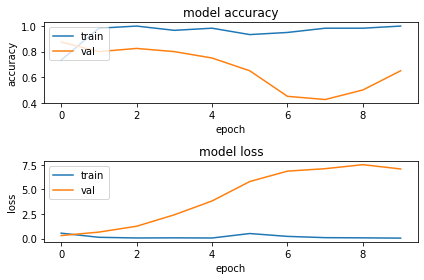

In [52]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left') 

plt.tight_layout()
plt.show()  

Well, we ended up with a *horrible* case of overfitting since the performance on the test cases is so bad, but we can at least get it to learn the training data (100%). We could, of course, add *dropout* or some other regularization method to try to cope with this or provide some data augmentation to help it experience a wider data set, or just use a larger data set: this data set was kept small for the assignment, but larger data sets inherently prevent overfitting due to the broad range of experiences captures by such data. That is, we know for a fact that 60 images is a little **data starved** for this kind of task. So instead, let's just train up a conv net from scratch for 10 epochs for comparison, and see what it can do in that same amount of effort.

In [53]:
# A convolution net for the cat problem!
model = keras.Sequential()
# Three input channels this time!
model.add(keras.layers.Conv2D(64, kernel_size=(8, 8),
                              activation='relu',
                              input_shape=[X.shape[1],
                                           X.shape[2],
                                           X.shape[3]]))
model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(8, 8)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(Y.shape[1], activation='softmax'))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

# Roughly the same number of parameters!
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 292, 292, 64)      12352     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 285, 285, 128)     524416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 156800)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               20070528  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [54]:
batch_size = 20
epochs = 10
history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.4)

Epoch 1/10
3/3 [==============================] - 23s 8s/step - loss: 2.5624 - categorical_accuracy: 0.4688 - val_loss: 0.8609 - val_categorical_accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 23s 8s/step - loss: 0.7470 - categorical_accuracy: 0.4437 - val_loss: 0.6935 - val_categorical_accuracy: 0.6000
Epoch 3/10
3/3 [==============================] - 23s 8s/step - loss: 0.6906 - categorical_accuracy: 0.7604 - val_loss: 0.6953 - val_categorical_accuracy: 0.5500
Epoch 4/10
3/3 [==============================] - 23s 8s/step - loss: 0.6929 - categorical_accuracy: 0.5667 - val_loss: 0.7007 - val_categorical_accuracy: 0.5250
Epoch 5/10
3/3 [==============================] - 23s 8s/step - loss: 0.6708 - categorical_accuracy: 0.6604 - val_loss: 0.7145 - val_categorical_accuracy: 0.5750
Epoch 6/10
3/3 [==============================] - 23s 8s/step - loss: 0.6425 - categorical_accuracy: 0.7583 - val_loss: 0.7662 - val_categorical_accuracy: 0.4750
Epoch 7/10
3/3 [============

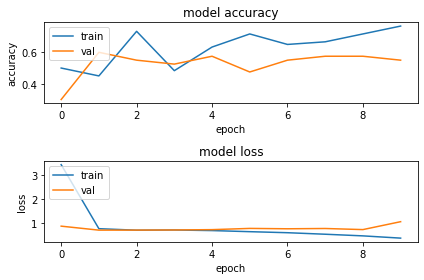

In [55]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left') 

plt.tight_layout()
plt.show()  

It may take a while to train these large networks, so starting from the pre-trained network is a *huge* advantage in most cases. Don't let the increase to 60% validation accuracy fool you on the "*from scratch*" network just above: we can see that it's starting to overfit, so it's not an indication of future performance. If we had performed **early stopping** with the Xception net above (go back and check epoch 2), you can see it was at 80% validation accuracy - a clear advantage. However, now that this new network has started to overfit, it's clear that it won't be able to achieve the same level of performance. Pre-trained networks, a form of **transfer learning**, are becoming more and more common in applications due to the large computational resources and careful tuning required for large-scale performance when training networks from scratch.